# Using Neural Networks for a Regression Problem

This notebooks demonstrates how to use neural networks to solve a regression problem using Python.  The specific issues is the determination of corporations' effective tax rate (ETR) based on various financial and operational features.  This example is based on the work of [Belnap, Kroeger, and Thornock (2023), "Explaining Tax Avoidance: Insights from Thirty Years of Research"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4530437).

In [55]:
# %%
import copy
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score
# from torchmetrics.regression import R2Score
import tqdm
from sklearn.model_selection import train_test_split
import os


In [56]:
CUR_DIR = os.getcwd()

# %%
# Choose sample to use
dep_var = "Cash ETR"

# Read data
df = pd.read_csv(os.path.join(CUR_DIR, "ETR_sample.csv"))


# %%
# Drop obs if missing any of indep or dep vars
THEORY_VARS = [
    # "Stock Compensation Mix",
    "Male_CEO",
    "Manager Ability",
    "Size",
    "Earnings Announcement Speed",
    "RankChangeZ",
    "RankChangeKZ",
    "NoDividends",
    "JunkRating",
    "R&D",
    "Intangible Intensity",
    "Foreign Income",
    "MNC",
    "BTM",
    "Capital Intensity",
    "ROA",
    "NOL",
    "Leverage",
    "fyear",
    "industry",
    "state",
]
indep_vars = THEORY_VARS
df = df[[dep_var] + indep_vars]
df.dropna(inplace=True)

/var/folders/bw/1cvntf9x02b49nfwgy_qnfn00000gp/T/ipykernel_97097/2943328671.py:8: DtypeWarning: Columns (11,27,31,34,35,36,946,947,949,956,971,989,990) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(CUR_DIR, "ETR_sample.csv"))


In [57]:
# %%
# Select data objects for NN
# One-hot encode the data using pandas get_dummies
df = pd.get_dummies(df, columns=["fyear", "state", "industry"])
# df.drop(columns=["fyear", "state", "industry"], inplace=True)
y = df[dep_var].values
X = df.loc[:, df.columns != dep_var].values
indep_vars = df.loc[:, df.columns != dep_var].columns.tolist()
num_vars = X.shape[1]


# train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, shuffle=True
)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train.astype(np.float64), dtype=torch.float32)
y_train = torch.tensor(y_train.astype(np.float64), dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.astype(np.float64), dtype=torch.float32)
y_test = torch.tensor(y_test.astype(np.float64), dtype=torch.float32).reshape(-1, 1)


In [58]:
# Define the model
# Here using a pyramid structure
model = nn.Sequential(
    nn.Linear(num_vars, num_vars * 10),
    nn.ReLU(),
    nn.Linear(num_vars * 10, num_vars * 10),
    nn.ReLU(),
    nn.Linear(num_vars * 10, 24),
    nn.ReLU(),
    nn.Linear(24, 1),
    nn.Sigmoid()  # or nn.Linear(24, 1),
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0005)


n_epochs = 2000  # number of epochs to run
batch_size = 1000  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history_mse = []
history_r2 = []

In [59]:
# Training loops
for epoch in range(n_epochs):
    model.train() # set model to training mode
    with tqdm.tqdm(
        batch_start, unit="batch", mininterval=0, disable=True
    ) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start : start + batch_size]
            y_batch = y_train[start : start + batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()  # set model to evaluation mode
    # y_pred = model(X_test)
    y_pred = model(X_train)
    # mse = loss_fn(y_pred, y_test)
    mse = loss_fn(y_pred, y_train)
    mse = float(mse)
    r2score = R2Score()
    # r2score.update(y_pred, y_test)
    r2score.update(y_pred, y_train)
    r2 = float(r2score.compute())
    history_mse.append(mse)
    history_r2.append(r2)
    print(f'Finished epoch {epoch}, latest loss {loss}')
    if mse < best_mse:
        best_mse = mse
        best_r2 = r2
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.4f" % best_mse)
print("RMSE: %.4f" % np.sqrt(best_mse))
print("R2: %.4f" % best_r2)



Finished epoch 0, latest loss 0.03448142483830452
Finished epoch 1, latest loss 0.03341291472315788
Finished epoch 2, latest loss 0.03339814022183418
Finished epoch 3, latest loss 0.03215450048446655
Finished epoch 4, latest loss 0.03182728588581085
Finished epoch 5, latest loss 0.03172815591096878
Finished epoch 6, latest loss 0.031503256410360336
Finished epoch 7, latest loss 0.031214004382491112
Finished epoch 8, latest loss 0.030903777107596397
Finished epoch 9, latest loss 0.030488314107060432
Finished epoch 10, latest loss 0.029905447736382484
Finished epoch 11, latest loss 0.030850248411297798
Finished epoch 12, latest loss 0.028417164459824562
Finished epoch 13, latest loss 0.027761945500969887
Finished epoch 14, latest loss 0.027154456824064255
Finished epoch 15, latest loss 0.026468642055988312
Finished epoch 16, latest loss 0.025679700076580048
Finished epoch 17, latest loss 0.02489393576979637
Finished epoch 18, latest loss 0.024133510887622833
Finished epoch 19, latest los

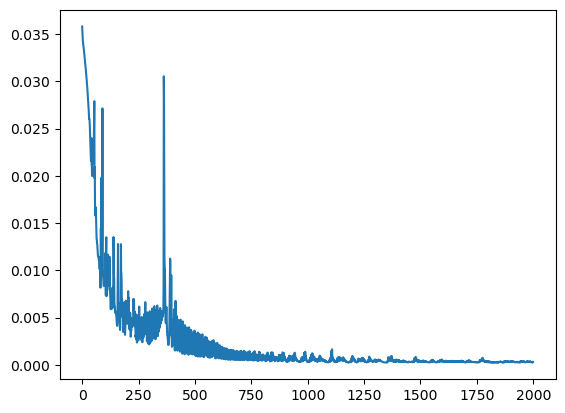

In [60]:
plt.plot(history_mse)
# limit y-axis
# plt.ylim(0, 0.04)
plt.show()

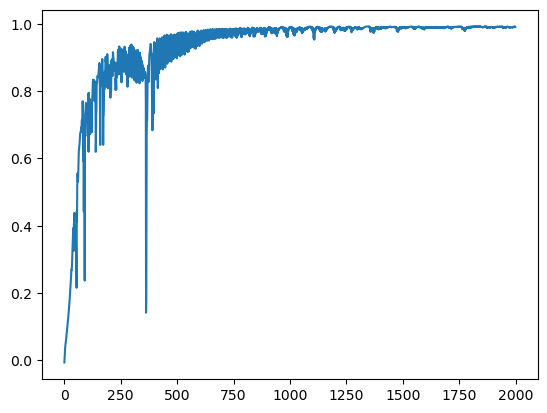

In [61]:
plt.plot(history_r2)
# limit y-axis
# plt.ylim(0, 1)
plt.show()

In [62]:
background = X_train[np.random.choice(X_train.shape[0], 1000, replace=False), :]
y_sample = y_train[np.random.choice(y_train.shape[0], 1000, replace=False)]


In [73]:
explainer = shap.DeepExplainer(model, background)
shap_values = explainer(X_train)  # Returns an Explanation object

In [74]:
feature_names = df.loc[:, df.columns != dep_var].columns.tolist()
# Set the feature names
shap_values.feature_names = feature_names
if len(shap_values.values.shape) == 3:
    shap_values.values = shap_values.values[:, :, 0]
# Set base values explicitly if they're None
if shap_values.base_values is None:
    shap_values.base_values = explainer.expected_value

/var/folders/bw/1cvntf9x02b49nfwgy_qnfn00000gp/T/ipykernel_97097/708081832.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


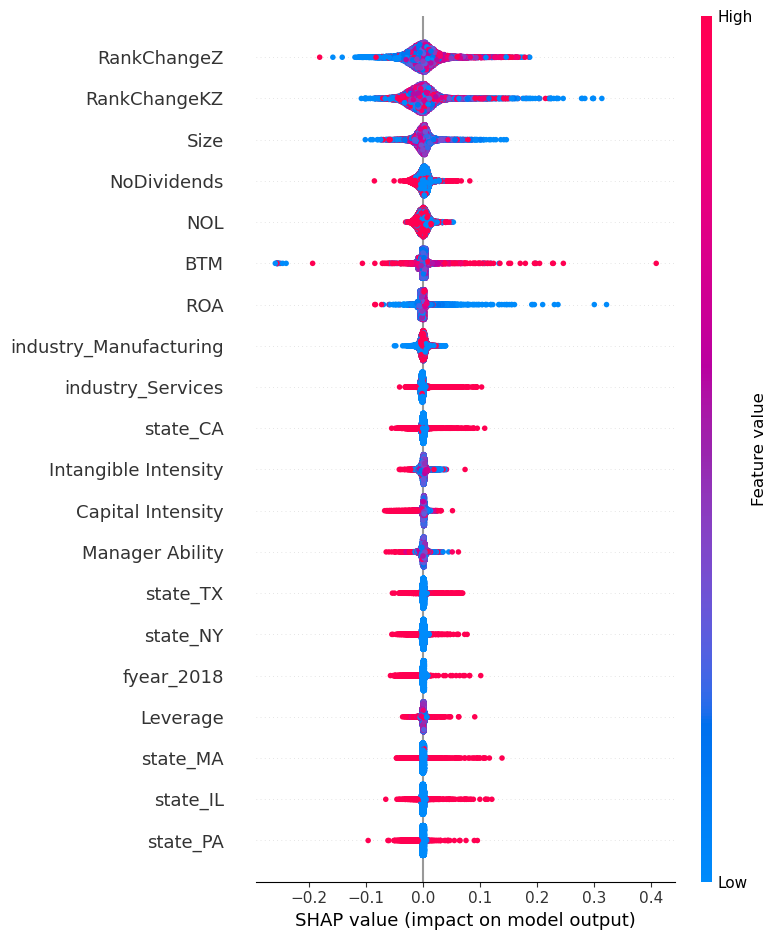

In [75]:
shap.summary_plot(shap_values, X_train, show=False)
fig2 = plt.gcf()
fig2.show()

/var/folders/bw/1cvntf9x02b49nfwgy_qnfn00000gp/T/ipykernel_97097/3053458473.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


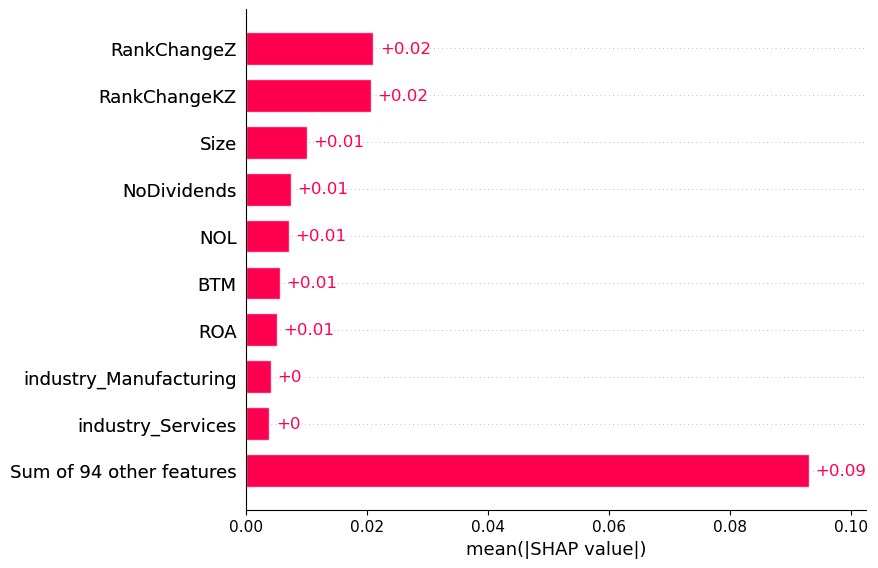

In [77]:
shap.plots.bar(shap_values,show=False)
fig2 = plt.gcf()
fig2.show()